### Load Data

In [1]:
from scipy.io import loadmat
import numpy as np
import random
from keras.utils import np_utils

data = loadmat('digit.mat')
#print(data.keys())
X = data['X']
T = data['T']
#print(X.shape)
D,NX,C = X.shape
#print(T.shape)
_,NT,_ = T.shape

Using TensorFlow backend.


### Preprocess Data

In [2]:
popu = [i for i in range(5000)]
random.shuffle(popu)
X_train = np.zeros((5000,256))
Y_train = np.zeros((5000))
X_test = np.zeros((2000,256))
Y_test = np.zeros((2000))
idx = 0
for i in popu:
    c = int(i/500)
    c_idx = int(i%500)
    X_train[idx,:]=X[:,c_idx,c]
    Y_train[idx]=c
    idx = idx+1
    
idx = 0
for i in range(10):
    for j in range(200):
        X_test[idx,:]=T[:,j,i]
        Y_test[idx]=i
        idx = idx+1

y_train = np_utils.to_categorical(Y_train,C)
y_test = np_utils.to_categorical(Y_test,C)

0


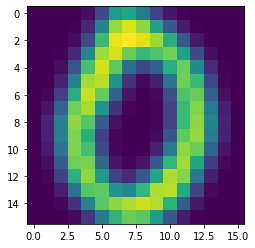

5


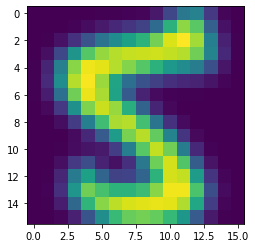

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
print(int((Y_train[4800]+1)%10))
plt.imshow(X_train[4800].reshape(16,16), interpolation='nearest')
plt.show()
print(int((Y_test[800]+1)%10))
plt.imshow(X_test[800].reshape(16,16), interpolation='nearest')
plt.show()

### Logistic Regression Model Training

In [4]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, Y_train)

/Users/rinmensai/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rinmensai/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


### Evaluation

In [5]:
result = clf.predict(X_test)
result = result.reshape((10,200))
#print(result)
confusion = np.zeros((C,C))
for i in range(C):
    for j in range(C):
        confusion[i,j] = np.sum(np.array([1 for k in result[i,:] if k==j]))
errors = []
TFs = np.zeros((C,3))
for i in range(C):
    fn = 0
    fp = 0
    for j in range(C):
        if j!=i:
            fn = fn + confusion[i][j]
            fp = fp + confusion[j][i]
    #print(s)
    TFs[i,0] = confusion[i,i]
    TFs[i,1] = fn
    TFs[i,2] = fp
    fn = fn/np.sum(confusion,axis=1)[i]
    errors.append(fn)
print("Class Errors:\n",errors)
print("Confusion Matrix:\n",confusion)
print("Error Rate: ",np.mean(errors))
print("Accuracy  : ",np.sum([[confusion[i][i] for i in range(C)]])/(NT*C))

Class Errors:
 [0.005, 0.08, 0.065, 0.05, 0.115, 0.04, 0.065, 0.13, 0.085, 0.02]
Confusion Matrix:
 [[199.   0.   0.   0.   1.   0.   0.   0.   0.   0.]
 [  0. 184.   0.   8.   0.   0.   2.   4.   1.   1.]
 [  0.   0. 187.   0.   7.   0.   2.   3.   0.   1.]
 [  0.   1.   0. 190.   1.   2.   0.   1.   5.   0.]
 [  0.   0.   9.   3. 177.   2.   0.   0.   4.   5.]
 [  0.   1.   0.   2.   1. 192.   0.   2.   0.   2.]
 [  1.   0.   1.   2.   1.   0. 187.   0.   8.   0.]
 [  0.   3.   7.   1.   6.   1.   1. 174.   1.   6.]
 [  2.   1.   0.   4.   0.   0.   5.   4. 183.   1.]
 [  0.   0.   1.   0.   1.   0.   0.   2.   0. 196.]]
Error Rate:  0.0655
Accuracy  :  0.9345


### Comparison with Fisher's Linear Discriminant Analysis 

In [6]:
from scipy.io import loadmat
import numpy as np

data = loadmat('digit.mat')
#print(data.keys())
X = data['X']
T = data['T']
#print(X.shape)
D,NX,C = X.shape
#print(T.shape)
_,NT,_ = T.shape

mean = np.zeros((D,C))
cov = np.zeros((D, D))

for i in range(C):
    mean[:,i] = np.mean(X[:,:,i],1)
    cov = cov + np.cov(X[:,:,i])/C

invS = np.linalg.pinv(cov)

p = np.zeros((C,NT,C))
for i in range(C):
    t = T[:,:,i]
    for j in range(C):
        m = mean[:,j]
        p[i,:,j] = np.dot(t.T,np.dot(invS,m)) - np.dot(m.T,np.dot(invS,m))/2.

P = np.argmax(p,axis=2)
confusion = np.zeros((C,C))
for i in range(C):
    for j in range(C):
        confusion[i,j] = np.sum(np.array([1 for k in P[i,:] if k==j]))

errors = []
TFs = np.zeros((C,3))
for i in range(C):
    fn = 0
    fp = 0
    for j in range(C):
        if j!=i:
            fn = fn + confusion[i][j]
            fp = fp + confusion[j][i]
    #print(s)
    TFs[i,0] = confusion[i,i]
    TFs[i,1] = fn
    TFs[i,2] = fp
    fn = fn/np.sum(confusion,axis=1)[i]
    errors.append(fn)

print("Confusion Matrix:\n",confusion)
print("Error Rate: ",np.mean(errors))
print("Accuracy  : ",np.sum([[confusion[i][i] for i in range(C)]])/(NT*C))
for i in range(C):
    print("=====Class #",((i+1)%10),"======")
    print("Errors    = ",(errors[i]))
    print("Recall    = ",(TFs[i,0]/(TFs[i,0]+TFs[i,1])))
    print("Precision = ",(TFs[i,0]/(TFs[i,0]+TFs[i,2])))

Confusion Matrix:
 [[199.   0.   0.   0.   1.   0.   0.   0.   0.   0.]
 [  0. 169.   8.   8.   1.   2.   4.   8.   0.   0.]
 [  0.   0. 182.   1.   5.   0.   2.   8.   1.   1.]
 [  2.   2.   0. 182.   0.   1.   0.   3.  10.   0.]
 [  0.   0.  21.   4. 162.   1.   0.   4.   4.   4.]
 [  1.   2.   0.   1.   5. 185.   0.   3.   0.   3.]
 [  2.   0.   1.   5.   1.   0. 181.   0.   9.   1.]
 [  0.   1.  16.   6.   6.   0.   1. 164.   3.   3.]
 [  1.   0.   0.   8.   0.   0.   7.   2. 182.   0.]
 [  0.   0.   3.   0.   0.   4.   0.   1.   0. 192.]]
Error Rate:  0.101
Accuracy  :  0.899
=====Class # 1 ======
Errors    =  0.005
Recall    =  0.995
Precision =  0.9707317073170731
=====Class # 2 ======
Errors    =  0.155
Recall    =  0.845
Precision =  0.9712643678160919
=====Class # 3 ======
Errors    =  0.09
Recall    =  0.91
Precision =  0.7878787878787878
=====Class # 4 ======
Errors    =  0.09
Recall    =  0.91
Precision =  0.8465116279069768
=====Class # 5 ======
Errors    =  0.19
Recall  